# Создание подписей к изображениям (без Attention)

В этой работе я собираюсь объединить классификацию изображений и генерацию подписи к ним. Набор данных Microsoft Common Object in Context [MSCOCO](https://cocodataset.org/#home) состоит из множества изображений и пяти подписей к каждому изображению.
Будем объединять предобученную сеть классификатора ResNet с NLP моделью 

<div style="text-align:center;">
  <img src="https://drive.google.com/uc?id=1XUfYNlfE0j-sCWgir84GyjMzDsSzUbUR" alt="bot" width=700" height="443">


Рисунок 1 - Архитектура сети

In [10]:
import random
import numpy as np
import torch
import torchvision as tv
import collections
import os
import re

import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import misc
from nltk.translate.bleu_score import corpus_bleu

from tqdm import tqdm
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms as T
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline  
!nvidia-smi

Mon May  8 19:43:31 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650       WDDM | 00000000:01:00.0  On |                  N/A |
| 26%   33C    P8                8W /  75W|   3349MiB /  4096MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Так как датасет слишком большой, поэтому закачаю лишь валидационную часть (~6 Gb)

In [11]:
# Данная ячейка загружает изображения
#!wget http://images.cocodataset.org/zips/val2014.zip
#!unzip val2014.zip

In [12]:
# Данная ячейка загружает описания к изображениям
#!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
#!unzip annotations_trainval2014.zip

Выделим фичи изображений с помощью сверточной части ResNet34. Выходной слой сверточной части с помошью flattern представим в вектор и будем это уже использовать далее.

Мы будем передавать изображения из MSCOCO через ResNet. Вместо того, чтобы просматривать выходные данные Resnet  после «softmax» операции, мы собираемся просмотреть слой непосредственно перед этим.

In [13]:
model = tv.models.resnet34(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
num_features = model.fc.in_features
print('Число фичей из одной фотки:', num_features)
model.fc = torch.nn.Identity()  # заменяем полносвязный слой на слой-тождественность

Число фичей из одной фотки: 512


Проверка выхода сети при подаче батча = 1 и фотки 3,224,224

In [15]:
test_tensor = torch.rand(1, 3, 224, 224)
out = model(test_tensor)
print(out.shape)

torch.Size([1, 512])


In [16]:
# Заморозка модели
for param in model.parameters():
    param.requires_grad = False

In [17]:
TRAIN_IMAGE_PATH = 'val2014'
ANNOTATION_PATH = 'annotations/captions_val2014.json'

# Создадим трансформации к изображениям:
transform = T.Compose([T.Resize(256), 
                       T.CenterCrop(224), 
                       T.ToTensor(), 
                       T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

# Создадим датасет:
dataset = tv.datasets.CocoCaptions(TRAIN_IMAGE_PATH, ANNOTATION_PATH, transform)

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [18]:
print('Количество изображений в выборке: ', len(dataset))

Количество изображений в выборке:  40504


## Кодируем наши подписи и устанавливаем лимит словаря

При использовании горячего кодирования длина вектора каждого слова равна количеству слов в словаре. Давайте ограничим размер наших обучающих данных, удалив редкие слова.

Увидем что хранится в датасете:

In [19]:
dataset[1]

(tensor([[[-0.8507, -0.8507, -0.8507,  ..., -0.7479, -0.4397, -0.2171],
          [-0.8678, -0.8678, -0.8335,  ..., -1.0219, -0.6623, -0.3541],
          [-0.8507, -0.8678, -0.8335,  ..., -1.1247, -0.5938, -0.3541],
          ...,
          [-1.2103, -1.1760, -1.1760,  ...,  0.2967,  0.3138,  0.3823],
          [-1.1760, -1.0904, -1.1247,  ...,  0.5364,  0.4508,  0.4851],
          [-1.1247, -1.1418, -1.1247,  ...,  0.4679,  0.6734,  0.6734]],
 
         [[-0.7752, -0.7577, -0.7052,  ..., -0.9328, -0.4951, -0.1975],
          [-0.7927, -0.7577, -0.7402,  ..., -1.0378, -0.7052, -0.2850],
          [-0.7577, -0.7577, -0.7227,  ..., -1.0903, -0.5826, -0.2675],
          ...,
          [-1.1429, -1.0903, -1.1253,  ...,  0.2577,  0.3452,  0.2927],
          [-1.1253, -1.0378, -1.0728,  ...,  0.4853,  0.4678,  0.4853],
          [-1.0553, -1.0553, -1.0553,  ...,  0.3803,  0.6604,  0.6604]],
 
         [[-0.4624, -0.5147, -0.4798,  ..., -0.8458, -0.4798, -0.1661],
          [-0.4798, -0.4798,

Это кортеж, в которм фотка и список с возможными описаниями этого изображения

Разделим по пробелам все слова в датасете и получим массив в котором каждое слово отдельный элемент. Это мы делаем для создания словаря и понимания часто встречаемых и редко встречаемых слов

Функция по предподготовке текстовых данных: (Убирает ненужные символы и приводит к нижнему регистру)

In [20]:
def process_word_list(word_list):
    processed_list = []
    for word in word_list:
        # Приводим слово к нижнему регистру
        word = word.lower()
        # Удаляем все символы, кроме букв
        word = re.sub(r'[^a-zA-Z]', '', word)
        # Добавляем обработанное слово в список
        processed_list.append(word)
    return processed_list

In [21]:
##Составим список всех предложений.
DatasetWordList=[]
for _, dataset_caption in dataset:
        DatasetWordList += process_word_list(str(dataset_caption).split())

In [22]:
print('столько слов обнаружил в созданном списке:', len(DatasetWordList))

столько слов обнаружил в созданном списке: 2146616


Получили словарь со словами и количеством их встреч в датасете:

In [23]:
#Определить количество различных слов
distinctwords = collections.Counter(DatasetWordList)

# Вывести только первые 7 элементов словаря
keys = list(distinctwords.keys())[:7]
values = list(distinctwords.values())[:7]
for i in range(len(keys)):
    print(keys[i], values[i])
print('...')

#Отсортируем
count_pairs = sorted(distinctwords.items(), key=lambda x: (-x[1], x[0])) #ascending order (возрастающий порядок)

this 2333
wire 228
metal 826
rack 322
holds 1156
several 3258
pairs 56
...


Получим список слов и отберем слова у которых встречаемость более 5 раз в датасете
Так же добавим отдельные значения BOS старта и EOS конца текста, PAD паддинга и UNK для замены тех слов что нет в словаре

In [24]:
# Выделим отдельно слова и значения частоты встречаемости этого слова
words, occurence = list(zip(*count_pairs))
print('occurence =', occurence[:15])
print('words = ', words[:15])
print('было значений:', len(words))

occurence = (335187, 74058, 69918, 68196, 62752, 53508, 47850, 33722, 29193, 24628, 23429, 18364, 17003, 16315, 14660)
words =  ('a', 'on', 'of', 'the', 'in', 'with', 'and', 'is', '', 'man', 'to', 'sitting', 'an', 'two', 'at')
было значений: 18348


In [25]:
DictionaryLength = occurence.index(5)  #индекс для слов, которые встречаются 5 раз и больше
words=['PAD','UNK','EOS','BOS'] + list(words)[:DictionaryLength]
word_to_id = dict(zip(words, range(len(words))))
print('words = ', words[:15])
print('стало значений с учетом + 4 новых кодов (РАЗМЕР СЛОВАРЯ):', len(words))

words =  ['PAD', 'UNK', 'EOS', 'BOS', 'a', 'on', 'of', 'the', 'in', 'with', 'and', 'is', '', 'man', 'to']
стало значений с учетом + 4 новых кодов (РАЗМЕР СЛОВАРЯ): 5910


Получили для кажого слова свой новый индекс:

In [28]:
# Вывести только первые 8 элементов словаря word_to_id
keys = list(word_to_id.keys())[:10]
values = list(word_to_id.values())[:10]
print('word_to_id словарь:')
for i in range(len(keys)):
    print(keys[i], values[i])
print('...')

word_to_id словарь:
PAD 0
UNK 1
EOS 2
BOS 3
a 4
on 5
of 6
the 7
in 8
with 9
...


Трансформация из исходного предложения:

Было:

In [48]:
dataset[0][1][1].split()

['A', 'dog', 'sleeping', 'on', 'a', 'show', 'rack', 'in', 'the', 'shoes.']

После функции перевода в lower и убирания лишних символов:

In [46]:
process_word_list(dataset[0][1][1].split())

['a', 'dog', 'sleeping', 'on', 'a', 'show', 'rack', 'in', 'the', 'shoes']

После кодировния согласно словарю стало:

In [52]:
[word_to_id[word] for word in process_word_list(dataset[0][1][1].split()) if word in word_to_id]

[4, 45, 363, 5, 4, 747, 637, 8, 7, 558]

Мы выбираем случайное предложение с описанием для каждой фотографии. Ограничиваем размер предложения в 20 слов, заставляя остальное паддингами. Добавляем в конце EOS

In [78]:
num_steps=20  # максимальный размер предложения на train

# Функция для даталоадера. На вход пришел массив размером batch_size из значений из датасета
def collate_sentences(list_data):
    images = []
    labels = []
    lens = []
    references = []
    for sample in list_data:
        image, label_ = sample
        label = random.choice(label_) #выбор случайного предложения из массива
        images.append(image)
        lens.append(len(label.split()) if len(label.split()) < num_steps else num_steps)  #длина предложения

        # Получим кодировку слов как в словаре и в конце добавим код EOS
        EmbeddedSentence=[word_to_id[word] for word in process_word_list(label.split()) if word in word_to_id]+[word_to_id['EOS']]
        
        # Заполняем паддингами короткие предложения после их окончания 
        if len(EmbeddedSentence)<num_steps:
            b=[word_to_id['PAD']] * num_steps
            b[:len(EmbeddedSentence)] = EmbeddedSentence

        # Если более длинное, то просто обрезаем
        elif len(EmbeddedSentence) > num_steps:
            b=EmbeddedSentence[:num_steps]
        else:
            b=EmbeddedSentence

        # Переводим в тензор:
        labels.append(torch.LongTensor(b))
        
        ref=[]
        for i in range(5):
            ref.append(process_word_list(label_[i].split()))
        references.append(ref)

    lens, indices = torch.sort(torch.LongTensor(lens), descending=True)
    images = torch.index_select(torch.stack(images), 0, indices)
    labels = torch.index_select(torch.stack(labels), 0, indices)
   

    return images, labels, lens, references

__images__ - батч из изображений (batch_size, 3, 224, 224)<br>
__labels__ - батч описаний (batch_size, num_steps) ,
где num_steps-максимальная длина предложения<br>
__lens__ - длина каждого предложения в виде тензора (batch_size)<br>
__references__ - 5 реальных предложений для каждого из элементов батча (все референсные предложения). Данный список участвует в расчете метрики corpus_blue. Так как размер может различаться поэтому в качестве list<br>

Cледующая ячейка объединяет в даталоудере несколько семплов из датасета в один батч. Пример батча из 4 фоток:

In [79]:
a, b, c, d =collate_sentences([dataset[0], dataset[1], dataset[2], dataset[3]])
print(a.shape)
print(b.shape)
print(c.shape)
print(len(d))

torch.Size([4, 3, 224, 224])
torch.Size([4, 20])
torch.Size([4])
4


Мы взяли уже готовую архитектуру для выделения фич из изображений и теперь создадим архитектуру которая по ним будем создавать текст с помощью LSTM ячеек:

Берем текст и приводим каждое слово с помощью Embedding в размерность feature_dim. Далее на выходе LSTM с сети с числом слоев num_layers получаем на финальной 20 позиции текста интересующий нас результат размерности num_hidden. Потом этот результат подаем на перцептрон с выходом размерностью слов в словаре - классификатор с большим числом вариантов Linear(num_hidden, dict_size)

In [4]:
class LLMModel(torch.nn.Module):
    def __init__(self, dict_size, input_dim, feature_dim, output_keep_prob, num_layers, num_hidden):
        super().__init__()
        self.embed = torch.nn.Embedding(dict_size, feature_dim)
        self.feature_dim = feature_dim
        self.lstm_cell = torch.nn.LSTM(feature_dim,
                                       batch_first=True,
                                       hidden_size=num_hidden, 
                                       num_layers=num_layers, 
                                       dropout=output_keep_prob)
        self.linear = torch.nn.Linear(num_hidden, dict_size)
    def forward(self, x, feature):
        '''
        x - описание картинки [batch_size, max_len_text], где max_len_text - длина максимальной последовательности (num_steps)
        feature - фичи после обработки CNN [batch_size, feature_dim]
        '''
        x = self.embed(x)
        # Получу [batch_size, max_len_text, feature_dim] - {word indices представление}

        # feature.unsqueeze(1) #Input: [batch_size, feature_dim], Output: [batch_size, 1, feature_dim]
        x = torch.cat([feature.unsqueeze(1), x], dim=1)[:,:-1,:] 
        # Мы сконкатиноровали: Input: [batch_size, 1, feature_dim] {image vector}, [batch_size, T, feature_dim] {word indices} 
        # Output: [batch_size, 1+max_len_text-1, feature_dim]


        o, _ = self.lstm_cell(x) # выход [batch_size, 1+max_len_text-1, num_hidden]
        return self.linear(o) #[BOS, 14, 25, 87, 34, EOS, PAD, PAD...] ideal case #[batch_size, max_len_text+1, dict_size]

Теперь мы будем обучать нашу LM. Мы будем использовать метод,  где на каждом временном шаге мы будем передавать RNN текущую подпись **И** вектор признаков изображения путем объединения каждый новый вход с вектором признаков.

Задание лосса:

### Задание лосса и параметров модели

In [98]:
#######################################################################################################
# Параметры
feature_dim = 512 #ResNet измененный мной
num_hidden = 300
num_steps = num_steps
dict_length = len(words)
batch_size = 100
num_layers = 3
#######################################################################################################
train_loader = torch.utils.data.DataLoader(dataset, batch_size, 
                                           shuffle=True, 
                                           collate_fn=collate_sentences,
                                           drop_last=True
                                          )

llm_model = LLMModel(len(word_to_id), feature_dim, feature_dim, 0.05, num_layers, num_hidden)
lr = 1e-3
optimizer = torch.optim.Adam(llm_model.parameters(), lr)
loss_func = torch.nn.CrossEntropyLoss(reduction="sum")

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
llm_model.to(device)
model.to(device)
EPOCHS = 10

def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    Средний по батчу accuracy предикта нужного слова в 1-5 наивысших скорах
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  
    return correct_total.item() * (100.0 / batch_size)

cuda:0


Метрика Corpus BLEU (Bilingual Evaluation Understudy) является одной из самых популярных метрик для оценки качества машинного перевода. Она основывается на сравнении машинного перевода с несколькими референсными переводами, которые были выполнены людьми. 

Алгоритм метрики Corpus BLEU вычисляет сходство между машинным переводом и каждым референсным переводом, используя простой алгоритм подсчета n-граммов (последовательностей из n слов). Затем, для каждого n-грамма, вычисляется количество вхождений этого n-грамма в машинный и референсный переводы. 

Далее, вычисляется точность (precision) машинного перевода для каждого n-грамма, как отношение количества вхождений данного n-грамма в машинный перевод к общему количеству вхождений этого n-грамма во всех переводах (машинных и референсных). 

Наконец, для получения общей метрики Corpus BLEU, вычисляется геометрическое среднее точности машинного перевода для всех n-граммов, с учетом длины машинного перевода и количества референсных переводов. 

Метрика Corpus BLEU позволяет оценить качество машинного перевода на уровне слов и фраз, а также учитывает разнообразие референсных переводов. Она широко используется в научных работах и соревнованиях по машинному переводу.

В нашем случае будем учитывать 5 референсных текстов правильного описания 

## Обучение модели:

In [99]:
model.eval()
llm_model.train()
for ep in range(EPOCHS):
    print(f'Началось обучение {ep+1} эпохи')
    loader = tqdm(enumerate(train_loader))
    for idx, data in loader:
        image, label, lens, references = data
        image, label = image.to(device), label.to(device)
        
        #Создадим вектор об изображении
        with torch.no_grad():
            feature = model(image)
        
        optimizer.zero_grad()

        # Добавление 'BOS' в начало предложения:
        start_symbol = label.new_full((label.size(0), 1), word_to_id['BOS'])
        # Данной строчкой мы нашли код [3] для BOS и получили его batch_size раз 

        input_label = torch.cat([start_symbol, label],dim=-1)[:,:num_steps]
        # Тут мы вставили +1 BOS символ в начало строки и отрезали конечный символ строки
        # стал размер [batch_size, 1+20-1] то есть исходный по итогу
      
        out = llm_model(input_label, feature)
        ''' 
        на выходе forward для каждого элемента батча [20, dict_size] размер выхода. Мы используем подход 
        teacher forcing тем самы каждое новое слово на этапе n предсказывается при знании n-1 
        реальных ответов, прошедших через lstm. При этом для генерации первого слова BOS используется 
        лишь знание о фичах изображения из ResNet
        '''

        scores = pack_padded_sequence(
            out, lens, batch_first=True
        ) # delete [PAD, PAD] чтоб честно считать лосс
        targets = pack_padded_sequence(
            input_label, lens, batch_first=True
        )

        # Calculate loss
        loss = loss_func(scores.data, targets.data)
        loss.backward()

        # Предотвращение Exploiding gradient (взрыва градиентов)
        torch.nn.utils.clip_grad_norm_(llm_model.parameters(), 5) #обрезка значений по величину=5
        optimizer.step()
        
        # Оценка accuracy по топ_К=5
        if idx % 150==0: # каждый сотый батч печатаем резы
            #top_k
            topk = accuracy(scores.data, targets.data, 5)
            
            #corpus_bleu метрика
            #candidates for corpus_bleu
            candidates=[]
            for i in range(len(label)):
                sentence=[words[ind] for ind in torch.argmax(out[i],dim=-1)]
                sentence_before_EOS = []
                # Отрежем стартовое слово и слова после EOS
                for word in sentence:
                    if (word == 'EOS') or (word == 'PAD'):
                        break
                    if word == 'BOS':
                        continue
                    else:
                        sentence_before_EOS.append(word)
                candidates.append(sentence_before_EOS)
            score = corpus_bleu(references, candidates)
            print(f"iteration: {idx+ep*len(train_loader)} loss: {loss.item()} topk: {topk} corpus_bleu: {score}")
    print('Конец обучения эпохи')
print('СЕТЬ ОБУЧЕНА')

Началось обучение 1 эпохи


1it [00:01,  1.49s/it]

iteration: 0 loss: 9321.67578125 topk: 0.0 corpus_bleu: 2.724274245007058e-232


151it [02:48,  1.16s/it]

iteration: 150 loss: 5018.70703125 topk: 41.1875589066918 corpus_bleu: 3.2983816820093484e-155


301it [05:35,  1.16s/it]

iteration: 300 loss: 4608.0107421875 topk: 47.15909090909091 corpus_bleu: 5.157609872338847e-155


405it [07:30,  1.11s/it]


Конец обучения эпохи
Началось обучение 2 эпохи


1it [00:01,  1.25s/it]

iteration: 405 loss: 4076.801513671875 topk: 50.30060120240481 corpus_bleu: 5.137283763948307e-155


151it [02:48,  1.15s/it]

iteration: 555 loss: 4331.3515625 topk: 49.67074317968015 corpus_bleu: 7.771570715976825e-79


301it [05:34,  1.15s/it]

iteration: 705 loss: 3881.660888671875 topk: 52.72904483430799 corpus_bleu: 8.3100537410138e-79


405it [07:30,  1.11s/it]


Конец обучения эпохи
Началось обучение 3 эпохи


1it [00:01,  1.27s/it]

iteration: 810 loss: 3991.558837890625 topk: 53.6150234741784 corpus_bleu: 8.9023449880618e-79


151it [02:48,  1.15s/it]

iteration: 960 loss: 3923.205322265625 topk: 54.54545454545455 corpus_bleu: 9.829248186949502e-79


301it [05:34,  1.16s/it]

iteration: 1110 loss: 3591.953857421875 topk: 57.56704980842912 corpus_bleu: 0.01503385493999058


405it [07:28,  1.11s/it]


Конец обучения эпохи
Началось обучение 4 эпохи


1it [00:01,  1.28s/it]

iteration: 1215 loss: 3302.904296875 topk: 58.30815709969789 corpus_bleu: 7.696622967837521e-79


151it [02:47,  1.15s/it]

iteration: 1365 loss: 3653.4306640625 topk: 59.14179104477612 corpus_bleu: 0.014605889975120802


301it [05:33,  1.14s/it]

iteration: 1515 loss: 3218.16357421875 topk: 61.86770428015564 corpus_bleu: 1.408631778511778e-78


405it [07:27,  1.11s/it]


Конец обучения эпохи
Началось обучение 5 эпохи


1it [00:01,  1.23s/it]

iteration: 1620 loss: 3218.782470703125 topk: 63.05372290292177 corpus_bleu: 0.026023549149555705


151it [02:45,  1.16s/it]

iteration: 1770 loss: 3283.34423828125 topk: 62.193927522037214 corpus_bleu: 0.026954891939751365


301it [05:30,  1.15s/it]

iteration: 1920 loss: 3316.530517578125 topk: 62.735849056603776 corpus_bleu: 0.020676552518013355


405it [07:24,  1.10s/it]


Конец обучения эпохи
Началось обучение 6 эпохи


1it [00:01,  1.22s/it]

iteration: 2025 loss: 2852.806884765625 topk: 66.26865671641791 corpus_bleu: 0.02001468714382922


151it [02:45,  1.15s/it]

iteration: 2175 loss: 3072.509033203125 topk: 67.55270394133822 corpus_bleu: 0.036211906604564324


301it [05:30,  1.14s/it]

iteration: 2325 loss: 3007.695068359375 topk: 66.2135922330097 corpus_bleu: 0.048705350699024


405it [07:24,  1.10s/it]


Конец обучения эпохи
Началось обучение 7 эпохи


1it [00:01,  1.23s/it]

iteration: 2430 loss: 3050.67578125 topk: 66.44981412639405 corpus_bleu: 0.047169527141912214


151it [02:46,  1.14s/it]

iteration: 2580 loss: 2906.9521484375 topk: 68.95893027698185 corpus_bleu: 0.0239240863141994


301it [05:31,  1.16s/it]

iteration: 2730 loss: 2715.33642578125 topk: 71.56488549618321 corpus_bleu: 0.01745657056672401


405it [07:25,  1.10s/it]


Конец обучения эпохи
Началось обучение 8 эпохи


1it [00:01,  1.21s/it]

iteration: 2835 loss: 3052.36865234375 topk: 66.29001883239171 corpus_bleu: 0.041228905407557866


151it [02:46,  1.15s/it]

iteration: 2985 loss: 2851.178955078125 topk: 67.06467661691542 corpus_bleu: 1.355481118344087e-78


301it [05:31,  1.15s/it]

iteration: 3135 loss: 2802.927490234375 topk: 67.31517509727627 corpus_bleu: 0.023285144316393433


405it [07:25,  1.10s/it]


Конец обучения эпохи
Началось обучение 9 эпохи


1it [00:01,  1.22s/it]

iteration: 3240 loss: 2830.123291015625 topk: 66.95992179863147 corpus_bleu: 1.2090416082643831e-78


151it [02:45,  1.15s/it]

iteration: 3390 loss: 3051.34375 topk: 63.951310861423224 corpus_bleu: 0.022361226294055837


301it [05:30,  1.14s/it]

iteration: 3540 loss: 2765.019775390625 topk: 69.04985888993414 corpus_bleu: 0.02787761126824165


405it [07:24,  1.10s/it]


Конец обучения эпохи
Началось обучение 10 эпохи


1it [00:01,  1.22s/it]

iteration: 3645 loss: 2625.721923828125 topk: 70.7436399217221 corpus_bleu: 1.1019995027726947e-78


151it [02:45,  1.14s/it]

iteration: 3795 loss: 2785.2353515625 topk: 70.45454545454545 corpus_bleu: 1.5611924843727363e-78


301it [05:30,  1.15s/it]

iteration: 3945 loss: 2557.9833984375 topk: 71.2890625 corpus_bleu: 0.04409860933479703


405it [07:24,  1.10s/it]

Конец обучения эпохи
СЕТЬ ОБУЧЕНА


Количество градиентных спусков на 1 эпоху:

In [100]:
len(train_loader)

405

Сохраним модель и загрузим ее:

In [5]:
torch.save(llm_model, 'model.pt')
llm_model = torch.load('model.pt')
model = tv.models.resnet34(pretrained=True)
model.fc = torch.nn.Identity()  # заменяем полносвязный слой на слой-тождественность

Выход каждого объекта в батче слудующий:

In [102]:
out[0].shape

torch.Size([20, 5910])

Вот как получить значение самого вероятного слова в каждый момент времени: <br>
PS: Данный номер согласно словарю можно перевести в конкретное слово по ключу

In [103]:
torch.argmax(out[25],dim=1)

tensor([  3,   4,  74,   5,   4, 254,   8,   5,  39,   6,   4,  62,   9,   0,
          0,   0,   0,   0,   0,   0], device='cuda:0')

__Посмотрим на результаты обучения.__  <br>Ячейка ниже показывает подпись к изображению. В данном случае мы видим не целиком собственное сочинение нейросетью а лишь генерацию каждого следующего слова N при подаче на вход реального предложения c N-1 числом слов. Так что результирующий предикт может быть грамматически несвязанным, так как он не учитывает свои предыдущие шаги генерации для выдачи нового слова

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


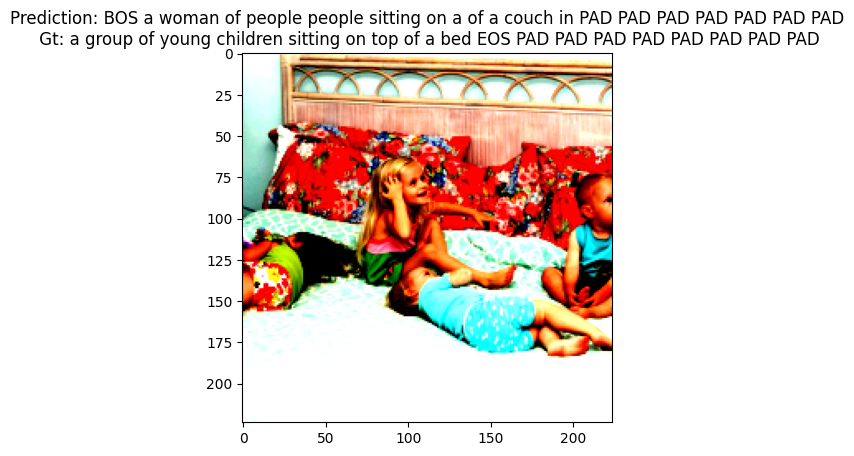

In [104]:
batch_id = 32
Prediction=' '.join([words[ind] for ind in torch.argmax(out[batch_id],dim=-1)])
Gt=' '.join([words[ind] for ind in label[batch_id]])

plt.title('Prediction: '+ Prediction+'\n Gt: '+Gt)
plt.imshow(image[batch_id].permute(1,2,0).cpu())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


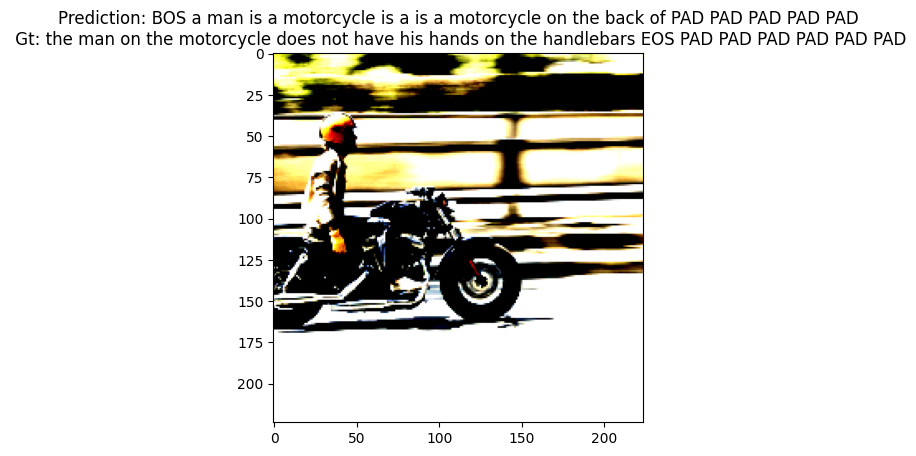

In [112]:
batch_id = 11
Prediction=' '.join([words[ind] for ind in torch.argmax(out[batch_id],dim=-1)])
Gt=' '.join([words[ind] for ind in label[batch_id]])

plt.title('Prediction: '+ Prediction+'\n Gt: '+Gt)
plt.imshow(image[batch_id].permute(1,2,0).cpu())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


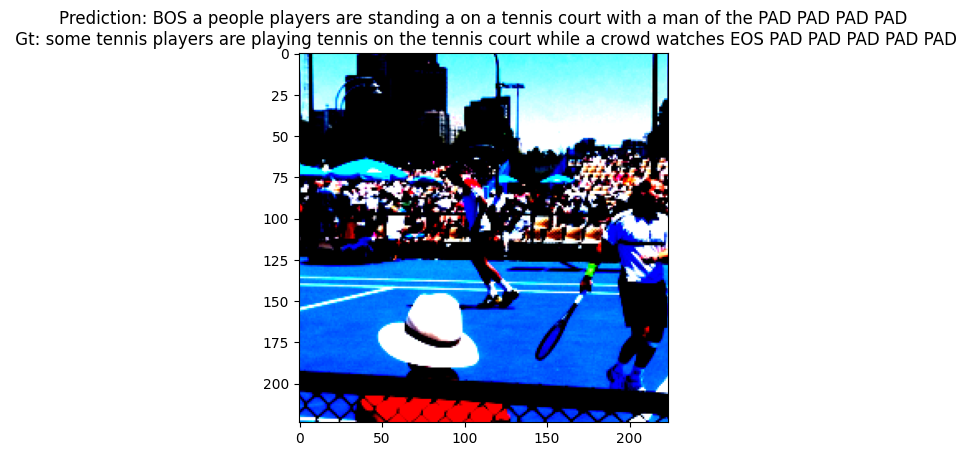

In [116]:
batch_id = 4
Prediction=' '.join([words[ind] for ind in torch.argmax(out[batch_id],dim=-1)])
Gt=' '.join([words[ind] for ind in label[batch_id]])

plt.title('Prediction: '+ Prediction+'\n Gt: '+Gt)
plt.imshow(image[batch_id].permute(1,2,0).cpu())
plt.show()

Проверим на валидационной выборке

In [117]:
val_dataset = dataset
val_loader = torch.utils.data.DataLoader(val_dataset, 1, 
                                           shuffle=True, 
                                           collate_fn=collate_sentences
                                          )

In [118]:
model.eval()
llm_model.eval()

loader = tqdm(enumerate(val_loader))

topks = []
for idx, data in loader:
    if idx<1000:
        image, label, lens, references = data
        image, label = image.to(device), label.to(device)
        with torch.no_grad():
            feature = model(image)

        start_symbol = label.new_full((label.size(0),1),word_to_id['BOS'])
        input_label = torch.cat([start_symbol, label],dim=-1)[:,:num_steps]

        out = llm_model(input_label, feature)
        scores = pack_padded_sequence(
            out, lens, batch_first=True
        )
        targets = pack_padded_sequence(
            label, lens, batch_first=True
        )

        topk = accuracy(scores.data, targets.data, 5)
        topks.append(topk)
        loader.set_description(f"iteration: {idx}") 
    else:
        break

iteration: 999: : 1000it [00:52, 18.98it/s]


In [119]:
print(f'Mean TopK: {np.mean(topks)}%') 

Mean TopK: 19.87323129570808%


__Попытка написать текст с нуля по новой фотке.__ <br>Вот алгоритм:


<div style="text-align:center;">
  <img src="https://drive.google.com/uc?id=1fnJ7zgSuXBjurRHGtJkirbqNpmZPewvs" alt="bot" width="1000" height="443">

До этого все наши генерированне предикты дыли всего лишь генерацией следующего слова при подаче на вход реального предложения с описанием. Сейчас же реализуем генерацию уникального предложения, на вход которого приходил лишь BOS а далее рекуррентно появляются слова за словами с соблюдением постепенно появляющегося контекста.

In [6]:
def generate_new(index=1):
    llm_model.eval()
    model.eval()

    # создаю путь к изображению
    image_path = f"val2014/{os.listdir('val2014')[index]}"

    # получение индекса по слову
    rev_word_map = {id: word for id, word in enumerate(words)}

    # считывание и трансформация 
    img = Image.open(image_path).convert('RGB')
    img = transform(img)    # (3, 224, 224)

    # Получим фичи из изображения
    encoder_image = model(img.unsqueeze(0).to(device))

    # LLM init
    # Инициализировал LSTM подав изображение
    step = 1
    h, c = llm_model.lstm_cell(encoder_image)
    # в с хранится текущее состояние рекуррентной LSTM ячейки 
    # (будет перезаписываться при прогоне)

    #Зададим первого слово BOS для первичного прогона:
    prev_words = torch.tensor([[word_to_id['BOS']]], dtype=torch.long).to(device)  
    seqs = prev_words   # размерность (1, 1)

    max_steps = 30  # Максимальный размер генерации если не будет EOS
    # цикл генерации
    while True:
        # Повторяем весь код инференса из llm модели (forward)
        embeddings = llm_model.embed(prev_words).squeeze(1)  # (1, embed_dim)
        # Мы текущее слово преставили в виде набора embed_dim чисел с 
        # помощью обученного слоя эмбеддинга

        # Прогон слова через LSTM с состоянием с
        h, c = llm_model.lstm_cell(embeddings, c)
        # Мы перезаписали на текущий момент состояние памяти с и получили output h
        # h имеет размер - [1, 256]

        # Прогон через линейный слой
        scores = llm_model.linear(h) # размерность [1, 11683]
        
        # С помошью greedy алгоритма берем самый вероятный предикт
        next_word_inds = torch.argmax(scores[0],dim=-1).unsqueeze(0)

        # Добавляем новое слово к уже сочиненным
        seqs = torch.cat([seqs, next_word_inds.unsqueeze(0)], dim=1)  # (1, step + 1)

        # Проверка на конец EOS для досрочного конца цикла:
        if next_word_inds[0] == word_to_id['EOS']:
            break

        # Выход по превышению лимита генерации
        if step > max_steps:
            break

        # Заменим текцих новый ответ на предыдущий для реализации новой генерации
        prev_words = next_word_inds
        step += 1

    # Превращаем сгенерированную последовательность в текст    
    seq = seqs[0].tolist()
    caption = [rev_word_map[ind] for ind in seq]

    # Выводим изображение и как подпись результат генерации:
    img = Image.open(image_path).convert('RGB')
    plt.title(f'Prediction: {" ".join(caption)}')
    plt.imshow(img)

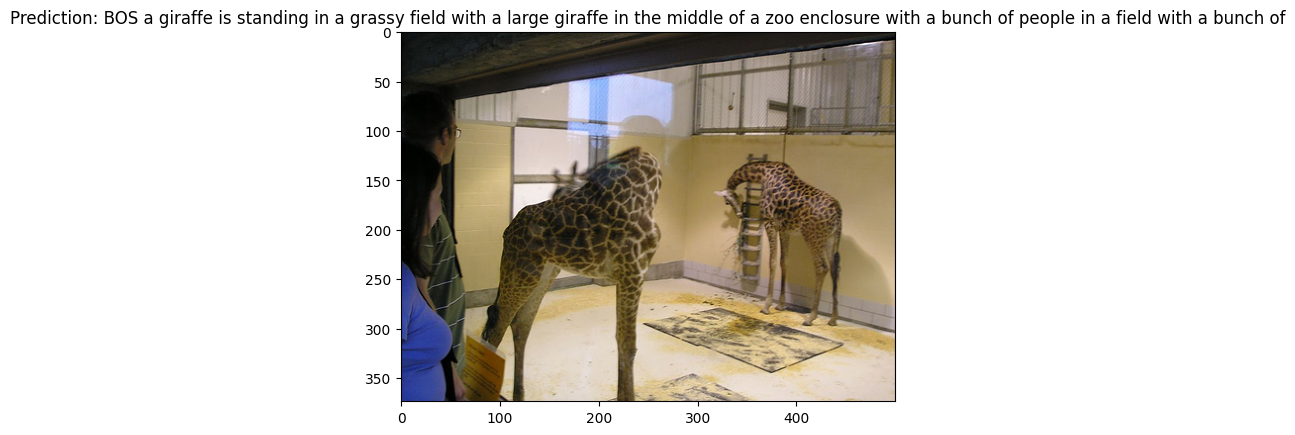

In [146]:
generate_new(4)

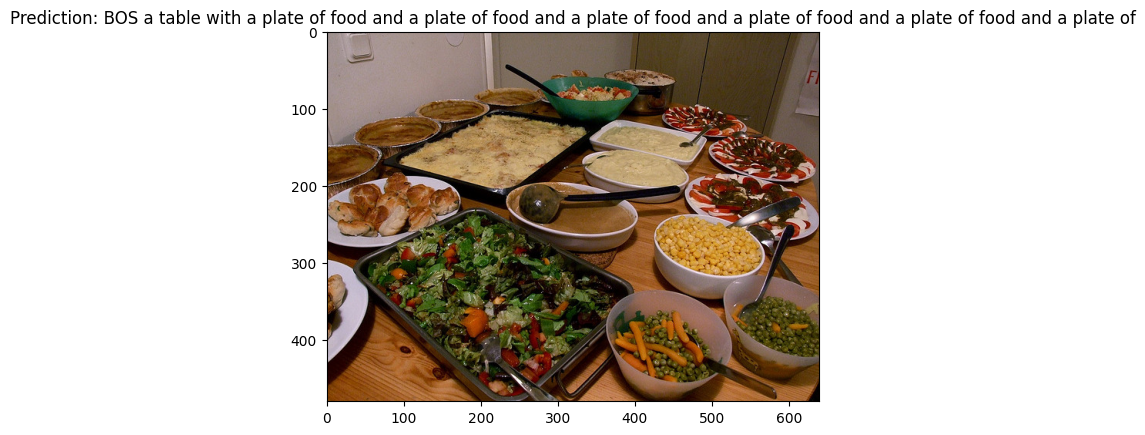

In [147]:
generate_new(9)

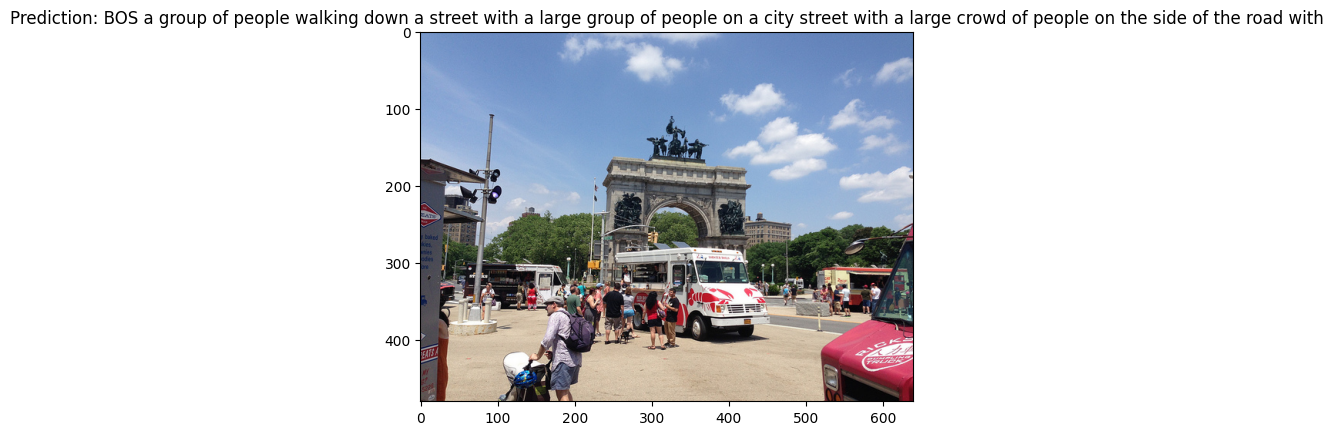

In [148]:
generate_new(12)

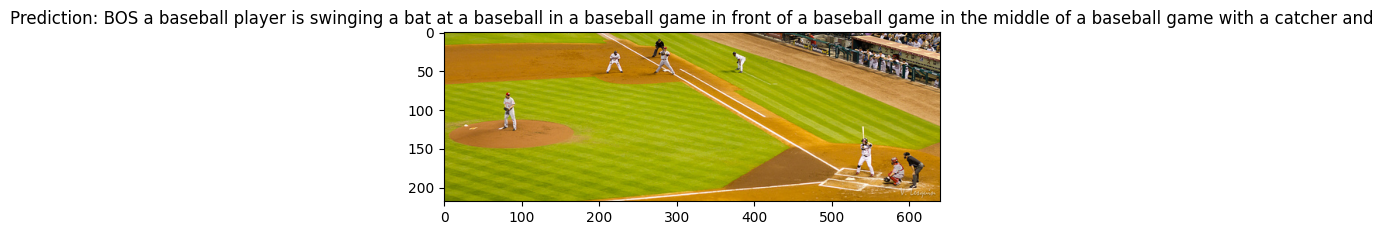

In [149]:
generate_new(18)

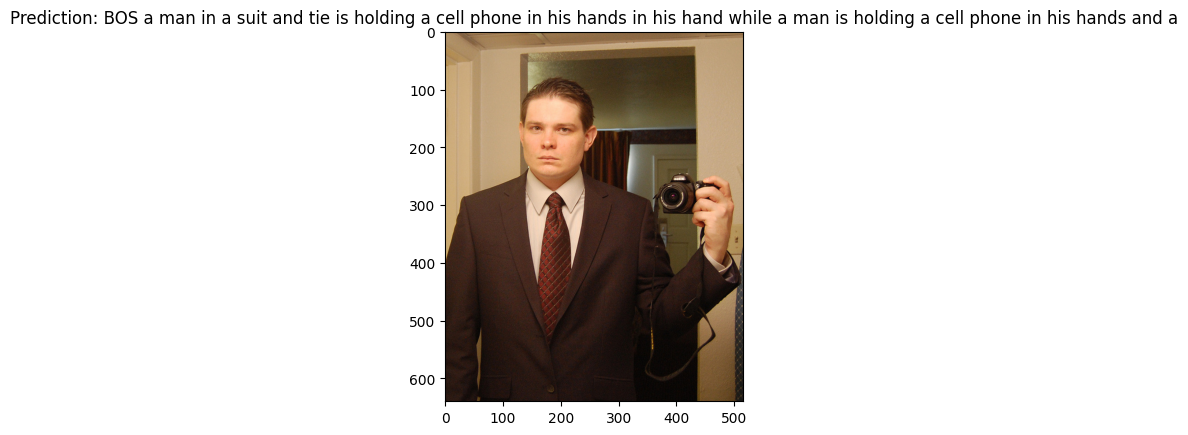

In [150]:
generate_new(27)

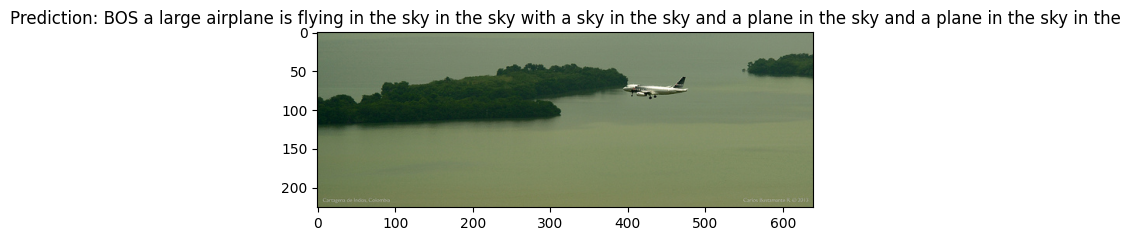

In [151]:
generate_new(28)

### __Вывод__:
Мы получили достаточно неплохие описания. Сеть действительно научилась "видеть" закономерности и выдавать описания, в которых как минимум есть то, что изображено (имеются нужные опорные слова). Единственная проблема заключается в том, что сеть не умеет давать ответ емко и лаконично. EOS практически не генерится самостоятельно. В итоге сеть не понимает когда стоит предложение интуитивно завершить. По этой причине иногда сеть зацикливается как будто забывая уже написанный контекст или просто обрывается на 30 словах так как я поставил такие ограничения при генерации.

Я могу предположить что это связано с ограничениями LSTM по удержанию памяти. Все же на эпохе генерации более 10 слова сеть уже практически полностью забывает контекст самого изображения и лишь выдает генерацию на основе предыдущих слов (то есть просто нагло сочиняет ахаха). Такую проблему решает онозначно сети на схожей архитектуре но с использованием attention механизмов, которые позволяют на каждом этапе генерации вновь обращаться к изображению (а точнее конкретной области его) для сочинения нового контекстно-обоснованного слова.

Так же я экспериментировал с функцией по предобработке слов и заметил, что если я не убираю никакие посторонние символы то появляются в словаре отдельные слова такого вида: "day" и "day." и так со всеми. Мы тем самым считаем это будто разными словами хотя это одно и то же. Если обучить сеть, оставив такой вариант, то будем получать метрику Mean TopK значительно ниже, но в таком случае при генерации самостоятельной чаще будут окончания предложений самостоятельно а не из-за требуемого программного ограничения в 30 слов. Так что если при генерации появлялось слово с точкой на конце, то точно при подаче его вновь на вход рекуррентке появлялся символ EOS и генерация завершалась. Вот такое необычное наблюдение.

## Ссылки 

[1]Vinyals, Oriol, et al. "Show and tell: Lessons learned from the 2015 mscoco image captioning challenge." IEEE transactions on pattern analysis and machine intelligence 39.4 (2017): 652-663.

[2]Xu, Kelvin, et al. "Show, attend and tell: Neural image caption generation with visual attention." International conference on machine learning. PMLR, 2015.

[3]Lin, Tsung-Yi, et al. "Microsoft coco: Common objects in context." European Conference on Computer Vision. Springer International Publishing, 2014.

---

Пример работы функции из generation.py:

A zebra standing in a field next to a tree in a grassy field with trees in the middle of the field with trees in the grass in the grass in ...


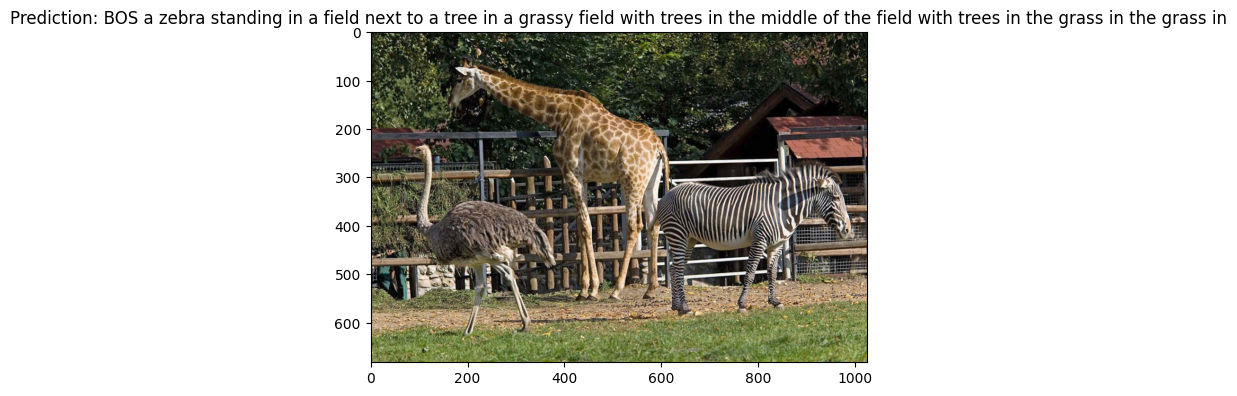

In [2]:
from generation import *
img = Image.open('test_images\zoo.jpg')
caption = predict(img, show=True)
print(caption)

In [3]:
from generation import *
img = Image.open('test_images\paren-s-telefonom-dva-smartfona.jpg')
caption = predict(img)
print(caption)

A man in a suit and tie is holding a cell phone in his hand and a man in a suit and tie is holding a cell phone in his hand ...


Посмотрим предикт при использовании механизма внимания при генерации для данного изображения (это вторая обученная мною модель model_attention.pt):

In [1]:
from generation_att import *
img = Image.open('test_images\paren-s-telefonom-dva-smartfona.jpg')
caption = predict_att(img)
print(caption)

A man in a suit and tie standing next to a woman holding a cell phone in her hand
